<a href="https://colab.research.google.com/github/jasondrebber/GEOL558/blob/main/SupervisedClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Alaskan Rocks using XRF data
## Jason Drebber
####2/8/2025

For this project I selected geochemical data from the USGS which records XRF data and rock classifications for over 3,000 rocks in northern Alaska. I intend to use the XRF data to classify the rock type (igneous, metamorphic, sedimentary) using the XRF data. In my research, I work with a significant number of igneous rocks for geochemical analysis and intend to do XRF analysis on many of them, so I am hoping to gain some familiarity with common XRF signature for different rock types that I can use to carry over to my work. I selected northern Alaska simply because it is intersting to me and I love learning about Alaska. All data used in this project is publicaly available from the USGS National Geochemical Database at https://mrdata.usgs.gov/ngdb/rock/geo-inventory.php

### Imports

In [1]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import SMOTE
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree

import warnings as wr
wr.filterwarnings("ignore")

### Load Data

This data is downloaded from the USGS National Geochemical Database (ngdb) for rock data. I specifically selected Alaska in the data viewer and then reduced the selecction further to download only the North-Slope rock data. This data represents rock classifications from the northernmost part of Alaska including the rock type (label) and the XRF data (feature matrix) that I can use to predict the rock type using different classification algorithms. The data exists in two separate CSV files. The first is all of the raw rock data which includes many unnecessary paramters msot of which are NaNs. The second CSV file has the associated XRF data for each rock in a large number of columns for each element. Most columns do not have any data because they are only measured on a small number of samples, so these will be removed in pre-processing.

In [2]:
# Load the raw rock data data
url1 =  'https://raw.githubusercontent.com/jasondrebber/GEOL558/fb0bd8e8f83a6058dfc07740c182f7c37326c59b/tblRockGeoData.txt'
raw_rock = pd.read_csv(url1)
raw_rock.head()

,lab_id,job_id,submitter,date_sub,field_id,state,country,datum,spheroid,latitude,...,mineralztn,alteration,struct_src,dep_envirn,source_rk,metamrphsm,facies_grd,prep,mesh_size,Unnamed: 31
0,ACF401,HM692,"Brew, David A.",19670918,67ABD006A,AK,NaN,NaN,NaN,58.52647,...,NaN,Fe alteration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ACF451,HM692,"Brew, David A.",19670918,67ABD081D,AK,NaN,NaN,NaN,58.57964,...,mineralization present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ACF452,HM692,"Brew, David A.",19670918,67ABD082B,AK,NaN,NaN,NaN,58.58703,...,NaN,Fe alteration,pluton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACF453,HM692,"Brew, David A.",19670918,67ABD090B,AK,NaN,NaN,NaN,58.60992,...,NaN,Fe alteration,pluton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACF454,HM692,"Brew, David A.",19670918,67ABD106,AK,NaN,NaN,NaN,58.65139,...,vein,Fe alteration,dike/sill,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Load the raw XRF data
url2 = 'https://raw.githubusercontent.com/jasondrebber/GEOL558/fb0bd8e8f83a6058dfc07740c182f7c37326c59b/xtbMajorChem.txt'
raw_chem = pd.read_csv(url2)
raw_chem.head()

,lab_id,sio2_xrf,sio2_xrfq,sio2_grv,sio2_grvq,sio2_aes,sio2_aesq,sio2_aa,sio2_aaq,sio2_clr,...,cl_mscq,cl_unk,cl_unkq,f_elctrd,f_elctrdq,f_msc,f_mscq,f_unk,f_unkq,Unnamed: 191
0,C105286,54.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C105287,79.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C105288,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C105289,62.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C105290,82.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pre-processing

In the code below I will perform initial pre-processing on the data. I start with saving only the columns of data that I want to work with and exclude the columns that contain unnecessary data, other meta-data that has a lot of NaNs, or inconsistently formatted data. This was determined through detailed evaluation of the raw data downloaded from the USGS. From the Rock data CSV file I saved three columns, the "lab_id" which is needed to connect the features to the targets, and the "secondary class" and "specific name" columns which store the rock type and specific lithology (see below for examples). From the chemcial or xrf data table I kept the most common XRF measurements that were available (SiO2, Al2O3, Fe2O3, Mgo, CaO, Na2O, K2O, TiO2,P2O5, MnO) and the "lab_id" field which is needed to connect the features to the target values. Next I combined the two raw data files based on the common attribute (lab_id) then checked for NaN values and removed them. I did not lose any significant amount of data fromm this because most of the rows of data which did not have one of the XRF data types did not have all of them making those samples fairly useless for classification. There were around 973 columns that had NaNs for almost all of the data and checking the shape of the data before removing NaNs there were 4651 samples, which dropped to 3614 meaning that 1,037 samples were lost, only 60 more than the average number of NaN values. This demonstrates that the samples with missing data were in fact consistent across most of the rows. Since this was the case I decided not to impute data, and instead simply removed them from the dataset. Finally I performed some basic data analysis on the data to analyze possible trends in the data through both numeric statistical and graphical means.

In [4]:
# Save only necessary columns from the rocks data frame
rock = raw_rock[['lab_id', 'xndryclass', 'spec_name']]
rock.head()

,lab_id,xndryclass,spec_name
0,ACF401,metamorphic,gneiss
1,ACF451,igneous,unspecified
2,ACF452,igneous,granite
3,ACF453,igneous,mafic
4,ACF454,igneous,unspecified


In [5]:
# Save only necessary columns from the chem data frame
chem = raw_chem[['lab_id', 'sio2_xrf', 'al2o3_xrf', 'feto3_xrf', 'mgo_xrf', 'cao_xrf', 'na2o_xrf', 'k2o_xrf', 'tio2_xrf', 'p2o5_xrf', 'mno_xrf']]
chem.head()

,lab_id,sio2_xrf,al2o3_xrf,feto3_xrf,mgo_xrf,cao_xrf,na2o_xrf,k2o_xrf,tio2_xrf,p2o5_xrf,mno_xrf
0,C105286,54.1,17.70,10.30,3.63,0.62,2.02,4.52,0.68,0.25,0.04
1,C105287,79.6,6.51,2.88,0.73,0.54,0.15,1.78,0.29,0.47,0.01
2,C105288,82.1,7.78,2.10,1.50,0.03,0.99,1.69,0.27,0.09,0.04
3,C105289,62.1,12.70,5.74,3.65,4.31,4.23,0.26,0.70,0.27,0.06
4,C105290,82.8,7.99,1.96,0.90,0.34,0.98,1.30,0.35,0.18,0.02


In [6]:
# Combine the data based on the lab id feature
rock = pd.merge(rock, chem, on='lab_id')
rock.drop(columns=['lab_id'], inplace=True)
rock.head()

,xndryclass,spec_name,sio2_xrf,al2o3_xrf,feto3_xrf,mgo_xrf,cao_xrf,na2o_xrf,k2o_xrf,tio2_xrf,p2o5_xrf,mno_xrf
0,metamorphic,meta-argillite,54.1,17.70,10.30,3.63,0.62,2.02,4.52,0.68,0.25,0.04
1,metamorphic,phyllite,79.6,6.51,2.88,0.73,0.54,0.15,1.78,0.29,0.47,0.01
2,metamorphic,meta-argillite,82.1,7.78,2.10,1.50,0.03,0.99,1.69,0.27,0.09,0.04
3,metamorphic,meta-argillite,62.1,12.70,5.74,3.65,4.31,4.23,0.26,0.70,0.27,0.06
4,metamorphic,meta-argillite,82.8,7.99,1.96,0.90,0.34,0.98,1.30,0.35,0.18,0.02


In [7]:
# Look at basic features of the data
print(rock.shape)
rock.info()

(4651, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4651 entries, 0 to 4650
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   xndryclass  4651 non-null   object 
 1   spec_name   4499 non-null   object 
 2   sio2_xrf    3678 non-null   float64
 3   al2o3_xrf   3678 non-null   float64
 4   feto3_xrf   3678 non-null   float64
 5   mgo_xrf     3678 non-null   float64
 6   cao_xrf     3678 non-null   float64
 7   na2o_xrf    3678 non-null   float64
 8   k2o_xrf     3678 non-null   float64
 9   tio2_xrf    3678 non-null   float64
 10  p2o5_xrf    3673 non-null   float64
 11  mno_xrf     3677 non-null   float64
dtypes: float64(10), object(2)
memory usage: 436.2+ KB


In [8]:
# Check for NaNs in each column
rock.isna().sum()

,0
xndryclass,0
spec_name,152
sio2_xrf,973
al2o3_xrf,973
feto3_xrf,973
mgo_xrf,973
cao_xrf,973
na2o_xrf,973
k2o_xrf,973
tio2_xrf,973


In [9]:
# Drop the NaNs from each column
rock = rock.dropna()
print(rock.isna().sum())
print(rock.shape)

xndryclass    0
spec_name     0
sio2_xrf      0
al2o3_xrf     0
feto3_xrf     0
mgo_xrf       0
cao_xrf       0
na2o_xrf      0
k2o_xrf       0
tio2_xrf      0
p2o5_xrf      0
mno_xrf       0
dtype: int64
(3614, 12)


In [10]:
# Look at the summary statistics of the feature data
rock.describe()

,sio2_xrf,al2o3_xrf,feto3_xrf,mgo_xrf,cao_xrf,na2o_xrf,k2o_xrf,tio2_xrf,p2o5_xrf,mno_xrf
count,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000
mean,57.673129,14.592559,7.221242,3.933924,6.254962,3.182460,1.951547,0.804037,0.272894,0.155557
std,13.496444,4.383189,4.695447,4.675774,5.395458,1.624798,1.630993,0.651536,0.827463,0.287212
min,0.100000,0.100000,0.040000,0.020000,0.003000,0.150000,0.010000,0.020000,0.005000,0.007000
25%,48.300000,13.500000,3.510000,1.010000,2.460000,2.320000,0.720000,0.340000,0.100000,0.070000
50%,57.700000,15.700000,6.700000,2.780000,5.680000,3.430000,1.640000,0.660000,0.200000,0.130000
75%,67.000000,17.300000,10.400000,5.517500,8.617500,4.040000,2.680000,1.070000,0.310000,0.180000
max,98.700000,28.500000,65.600000,46.800000,54.400000,10.100000,11.100000,6.830000,32.100000,8.240000


In the summary statistics above it is clear that most rocks have the highst concentration of Silica, as indicated by the mean of 57%. The silica XRF data also has the highest standard deviation suggesting that it is the most variable among rock types. Additioanlly, silica has up to 98% concnetration in some rocks suggesting that they are almost pure quartz, where as it has a minimum close to zero suggesting that there are also rocks that contain almost no silica (likely limestone or other carbonates). The next highest concentration element was Aluminum which is also consistent with common rock type information. It has less variation than silica but still reaches close to zero, THe remaining elements are mostly trace or minor elements in other minerals depeneding on the lithology. I expect that the maximum value for calcium which is close to 54% is for limestone which is entirely calcium and carbon which I know is too smalle of an element to be measured using XRF and explains why it is not included here. The maximum of the Iron and Magnesium rocks around 65% and 48% respectively are likely in mafic rocks like basalt or potentiall ultramafic rocks. It is most surprising to me that Phosphorus is so high at 35% in some samples althoug hthe mean of 0.2 indicates that it is usually only a trace element. However looking at the data it appears that it may be a common sedimentary rock element in some lithologies.

In [11]:
# Look at counts of the number of each target
rock['xndryclass'].value_counts()

,count
xndryclass,
igneous,2383
metamorphic,1105
sedimentary,126


The data is fairly unbalanced here as indicated by the value counts for each rock type I am classifying. This is too bad but I will play around with balanced data later.

In [12]:
# Look at counts of the specific rock types
rock['spec_name'].value_counts()

,count
spec_name,
granodiorite,460
basalt,306
tonalite,287
greenstone,214
quartz diorite,178
...,...
olivine norite,1
metaclaystone,1
diabase porphyry,1


I considered trying to classify the rocks based on the specific name instead of only the secondary class (igneous, sedimentary or metamorphic) but evaluating the data for the value count based on the specific name there appears to be a number of samples that only have a single sample which would make classification of them very difficult. Future work could attempt to include all of the rock classification data for the entire united states in order to classify the data based on the specific name instead of the secondary rock type, but that is outside the scope of this project specifically. I hypothesize that this would involve a lot of manual effort to download all of the data for the US and then assess the quality of the data for accuracy by fixing mislabeled rock names and brining different naming conventions for various parts of the country into agreement.

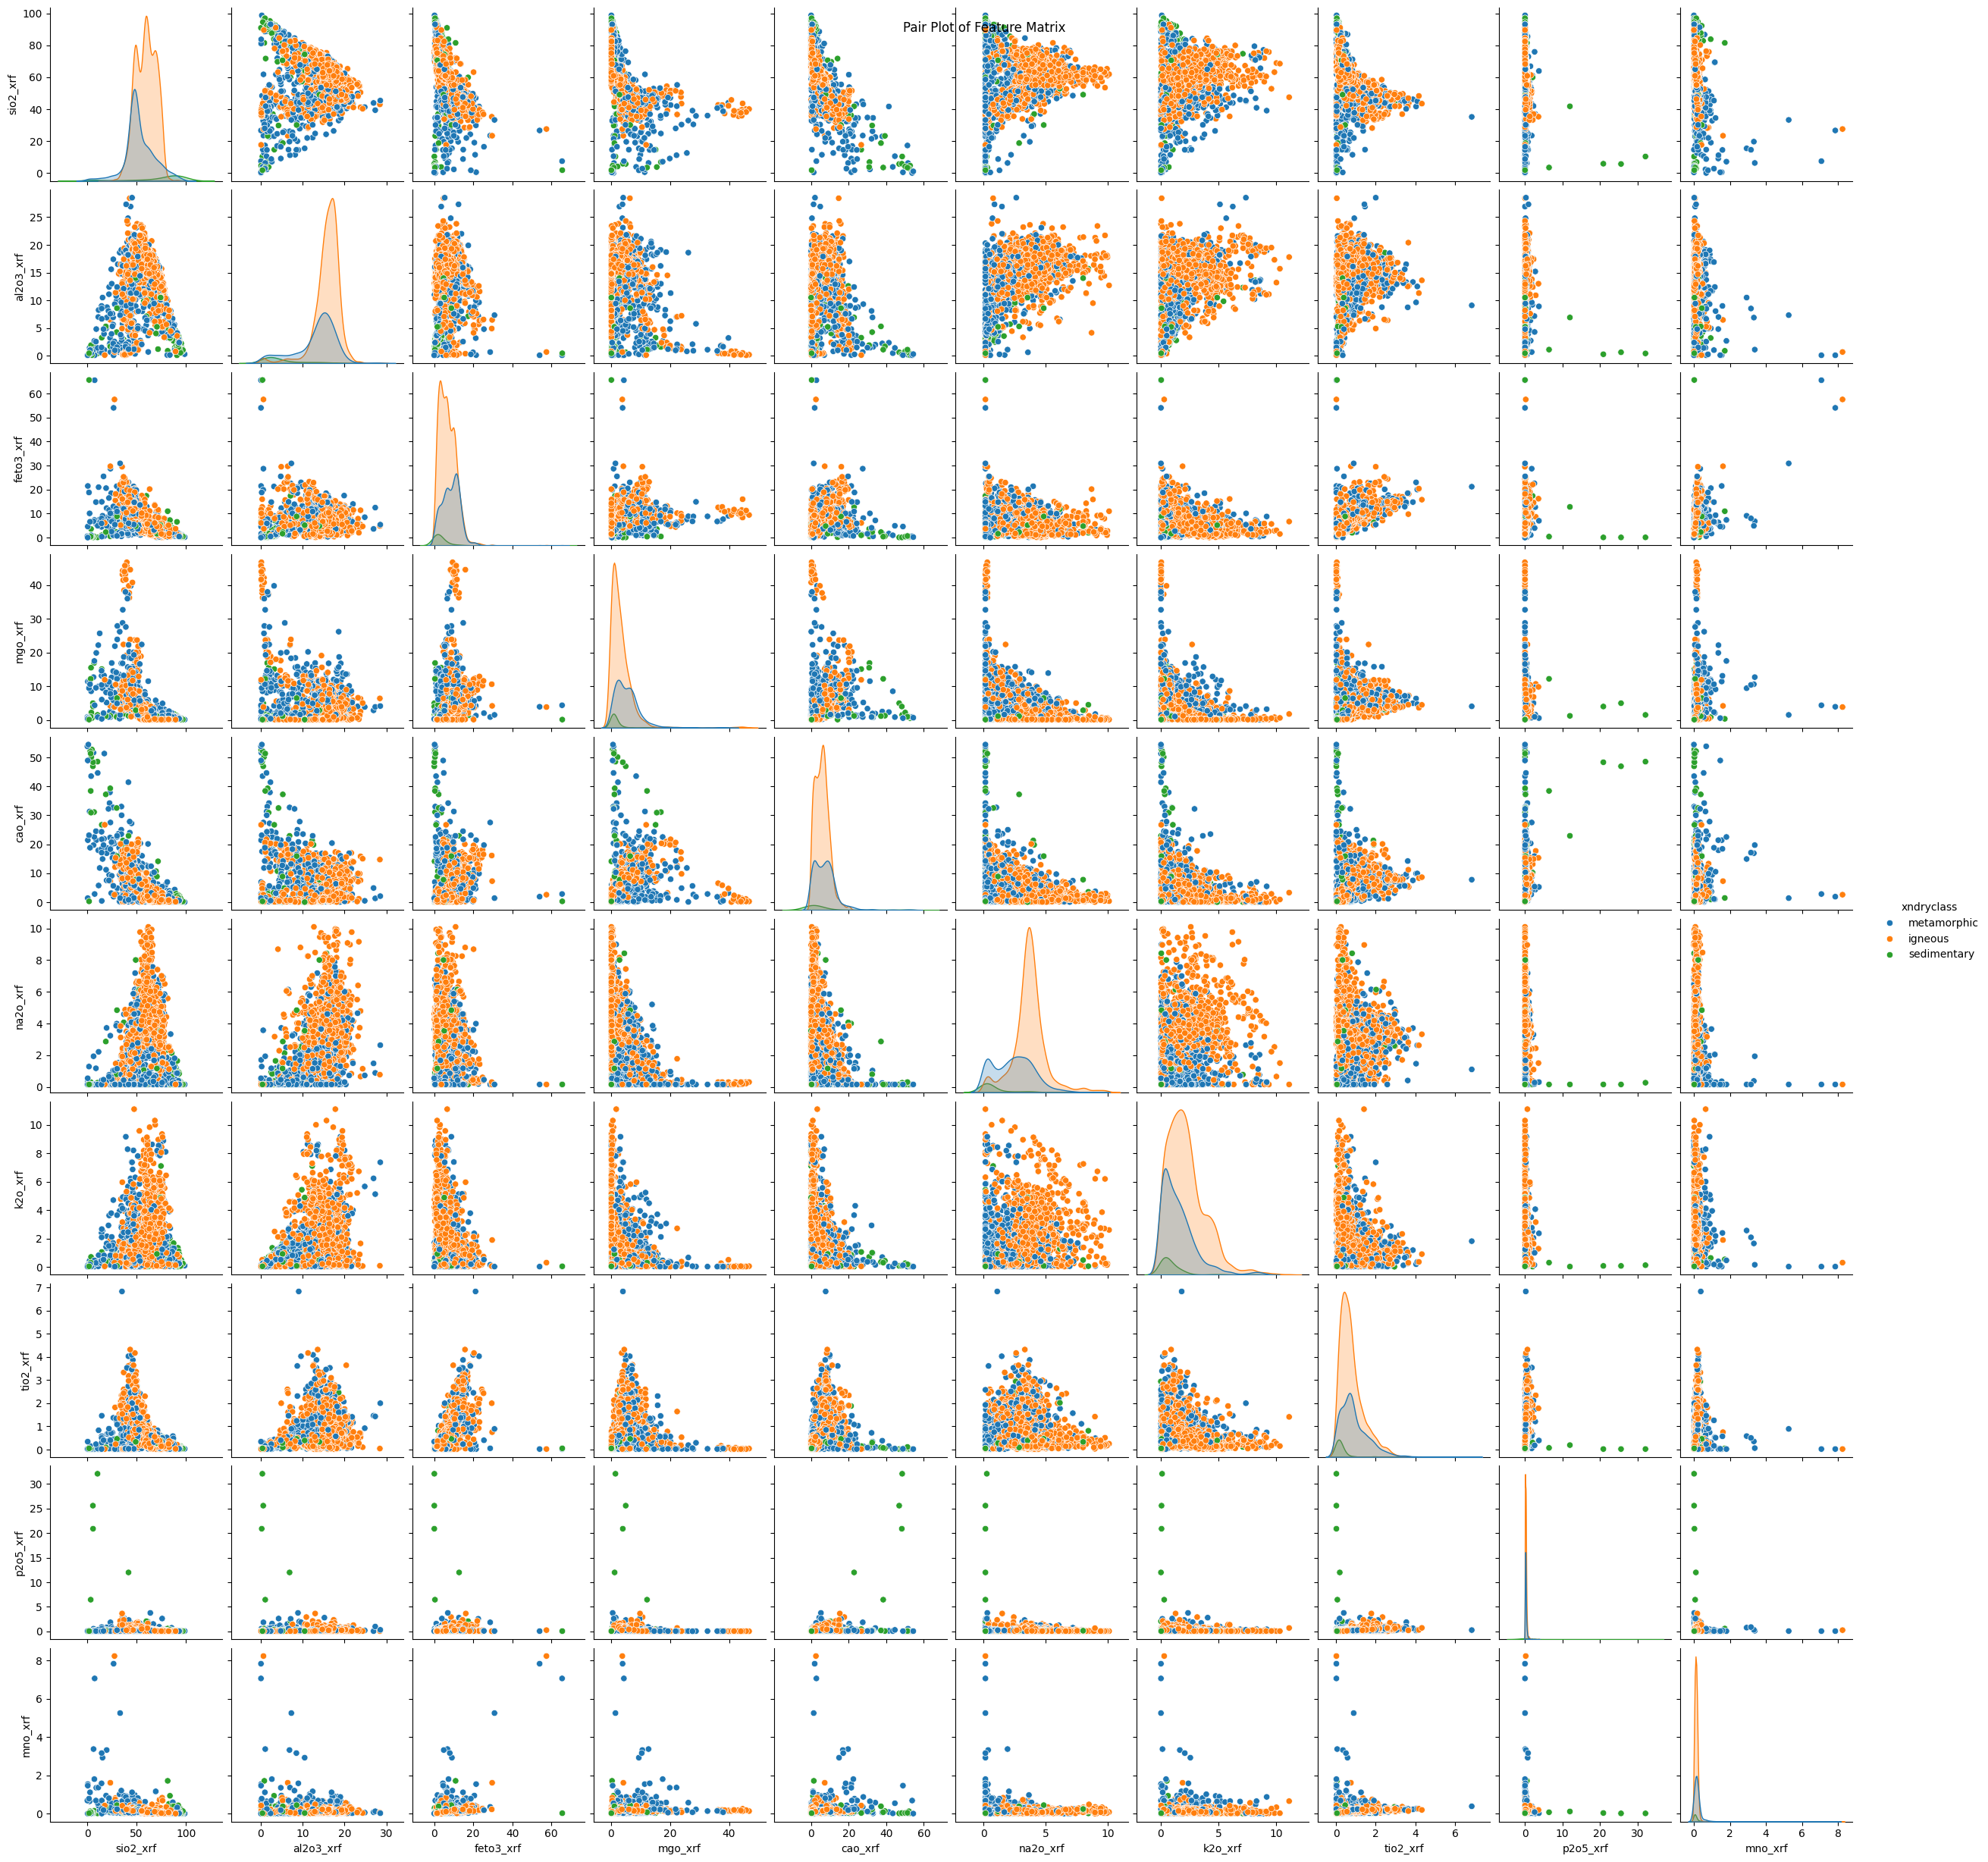

In [13]:
# Plot a seaborn pair plot of the feature matrix
sns.pairplot(rock, hue='xndryclass')
plt.suptitle('Pair Plot of Feature Matrix')
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap of Feature Matrix')

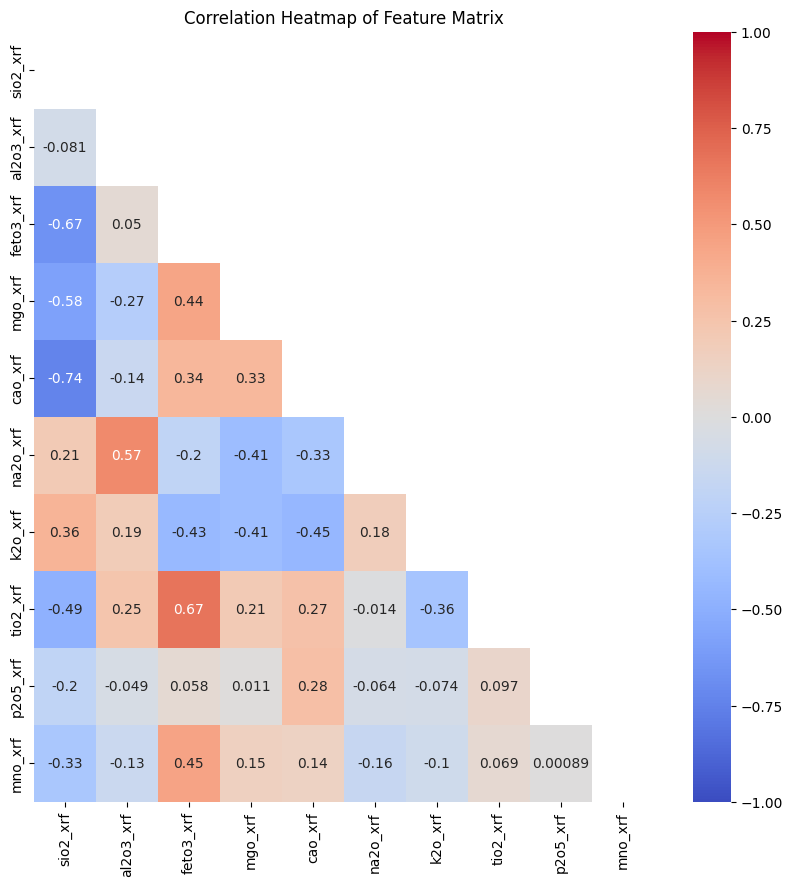

In [14]:
# Plot a correlation heatmap of the feature data with a divergent

# Compute the correlation matrix
corr = rock.select_dtypes('number').corr()

# Create an upper triangle mask
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,10))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, )
plt.title('Correlation Heatmap of Feature Matrix')

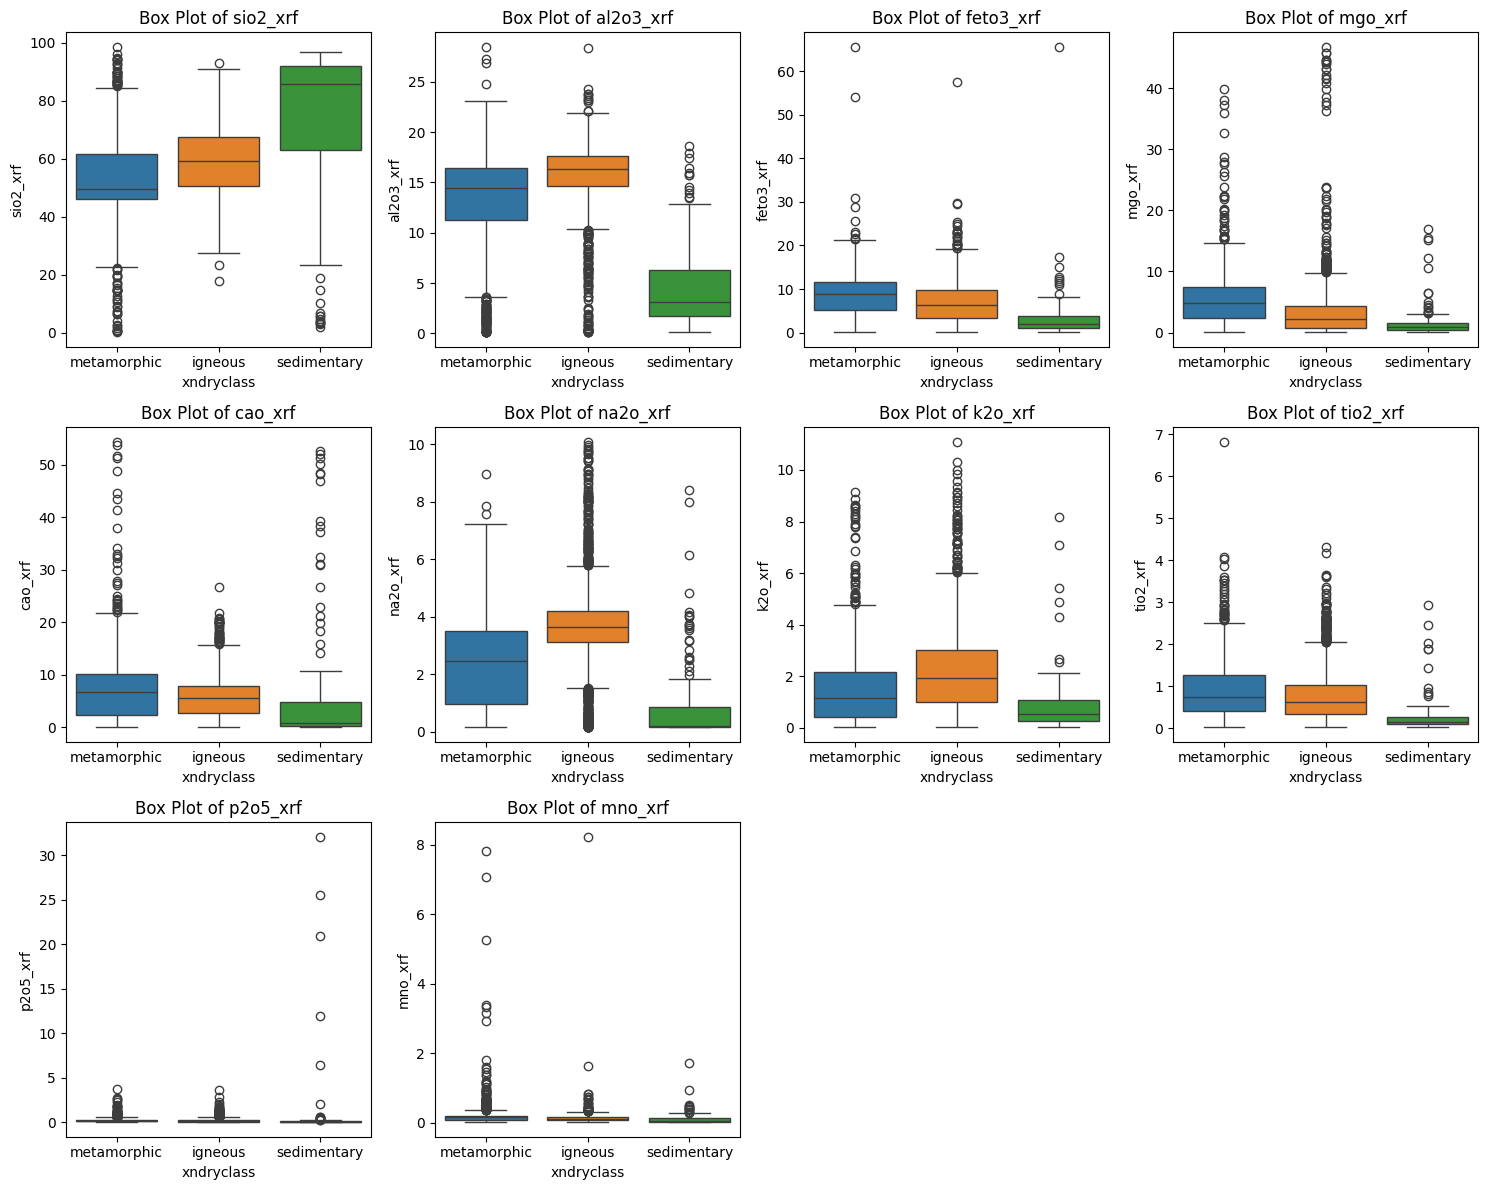

In [15]:
# Plot box plots for all of the features classed by the target to see how the features relate
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the features (excluding 'xndryclass' and 'spec_name')
for i, feature in enumerate(rock.columns.drop(['xndryclass', 'spec_name'])):
  # Create a box plot for the current feature grouped by 'xndryclass'
  sns.boxplot(x='xndryclass', y=feature, data=rock, ax=axes[i], hue='xndryclass')
  axes[i].set_title(f'Box Plot of {feature}')

# Remove any unused subplots
for i in range(len(rock.columns.drop(['xndryclass', 'spec_name'])), len(axes)):
  fig.delaxes(axes[i])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

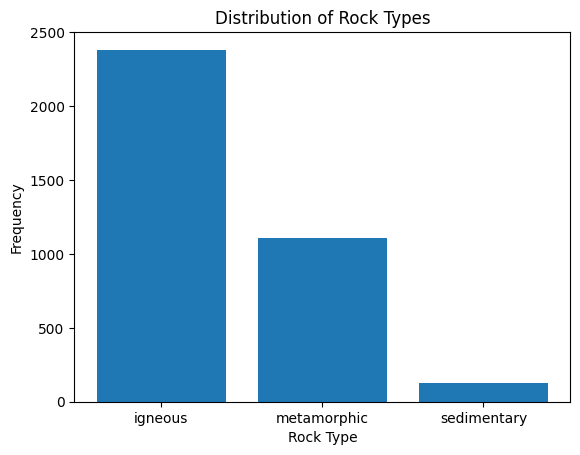

In [16]:
# Plot a bar chart of the different class features to see how many there are
plt.bar(x=rock['xndryclass'].value_counts().index, height=rock['xndryclass'].value_counts().values)
plt.xlabel("Rock Type")
plt.ylabel("Frequency")
plt.title("Distribution of Rock Types")
plt.show()

###### Summary of EDA

The above EDA shows some interesting and relevant trends which I expect will carry over into the classification. First of all I will point out that the data is somewhat unbalanced. There is a large amount of igneous rock data, somewhat less metamorphic rock data and only very little sedimentary data. I am curious how this will impact my classifier. If it appears to be an issue I will use a balancing tool to create samples of the data to make a balanced dataset. The first thing I notice in the numeric EDA is that on average SiO2 accounts for the highesst proportion of each rock type at 57%. This is followed by Al2O3 at 14.7%. Both of these align with my understanding of common rock composition so it is not very surprising. The other elements make up the rest and account for less than 10% each. Manganese, Phosphorus and Titanium all account for less than 1% on average however play more important rols in certain cases. For example Phosphorus which accounts for very little of most rocks can be up to 32% of some sediemntary rocks meaning that it may be more important for identifying and classifying sedimentary rocks when it is present in any significant porportion. Beyond the trend in phosphorus there is also an intersting relationship between SiO2 and Al2O3 in the scatter plot where SiO2 appears to be somewhat normally distributed around the mean value while Al2O3 varies more uniformly. This is somewhat odd of a relatiopnship for a scatter plot. The correlation heat map suggests that these two features are highly inversely related. And analysis of the box plots shows that sedimentary rocks on average have higher silica and lower alumnium content than either igneous or metamorphic rocks suggesting that these two are also indicative of sedimentary rocks in many cases. Igneous rocks in this area appear to have the highest sodium and potassium content suggesting that they are mostly alkaline igneous rocks and likely contain significant feldspars. I think that these features will be important for identifying the igenous rocks in this dataset. Other intersting trends is that Calcium, iron and magnesium are all highly negatively correlated with silica. Titanium and Iron are positiely correlated as are Aluminum and Calcium. It is apparent that many of the mafic elements vary inversely with the felsic elements. I think that overall this data is behaving exactly as I would expect it to.

This is not big data, this is only a few thousand samples of about 8 features so although it is a lot of data and would be hard to process by hand, it is not big data by most standards. I think if I included all of the rock classification data for the US then it would be big data. I actually tried to get the data for the entire US but it was too large to store in github so instead I just went with a specific area.

# Split Data

In [17]:
# Start by saving the targets to a vector and removing them from the feature matrix
target = rock['xndryclass']
rock.drop(columns=['xndryclass', 'spec_name'], inplace=True)

In [18]:
# Check the target vector to make sure it looks right
target.head()

,xndryclass
0,metamorphic
1,metamorphic
2,metamorphic
3,metamorphic
4,metamorphic


In [19]:
# Look at the feature matrix to make sure it looks okay also
rock.head()

,sio2_xrf,al2o3_xrf,feto3_xrf,mgo_xrf,cao_xrf,na2o_xrf,k2o_xrf,tio2_xrf,p2o5_xrf,mno_xrf
0,54.1,17.70,10.30,3.63,0.62,2.02,4.52,0.68,0.25,0.04
1,79.6,6.51,2.88,0.73,0.54,0.15,1.78,0.29,0.47,0.01
2,82.1,7.78,2.10,1.50,0.03,0.99,1.69,0.27,0.09,0.04
3,62.1,12.70,5.74,3.65,4.31,4.23,0.26,0.70,0.27,0.06
4,82.8,7.99,1.96,0.90,0.34,0.98,1.30,0.35,0.18,0.02


In [20]:
# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(rock)

I scaled the feature data for ths work in order to bring it into a common scale. The raw data is all on the same percentage scale so it may have been sufficient for model testing and classification without scaling, but using the standard scaler ensures that the data is all on a consistent scale and that some features (like silica) are not contributing more to the classification than other elements.

In [21]:
# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=23)

# Support Vector Machine


SVM Classifier Results:
              precision    recall  f1-score   support

     igneous       0.75      0.95      0.84       459
 metamorphic       0.77      0.35      0.48       243
 sedimentary       0.39      0.52      0.45        21

    accuracy                           0.74       723
   macro avg       0.64      0.61      0.59       723
weighted avg       0.74      0.74      0.71       723



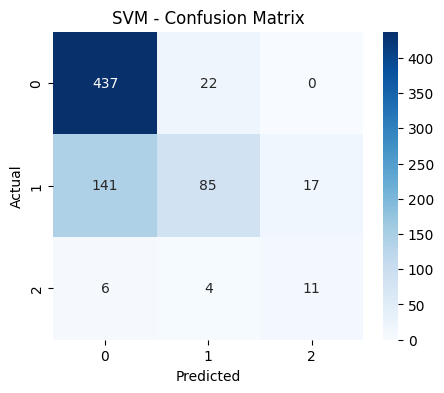


Support Vectors:
 [[-0.88725494  0.29832648  0.4342589  ...  1.32929372  0.35910578
   0.01547157]
 [-1.13920801 -0.72846528  1.50778762 ...  1.7898078   0.29867177
   0.22440569]
 [ 0.69115697  0.38959685 -0.67548012 ... -0.45136071 -0.06393229
  -0.26310725]
 ...
 [ 2.19546504 -2.09067569 -1.02906299 ... -0.85047291 -0.23314752
  -0.15864019]
 [ 2.53634273 -2.64057972 -1.29318513 ... -1.03467855 -0.26940793
  -0.47204137]
 [ 1.03944505 -3.05357818 -1.49553678 ... -1.14213183 -0.26940793
   0.50298451]]

Dual Coefficients:
 [[ 1.  1.  1. ... -1. -0. -0.]
 [ 0.  0.  0. ... -1. -1. -1.]]

Number of Support Vectors per Class:
 [719 763  93]
CPU times: user 1.03 s, sys: 189 ms, total: 1.22 s
Wall time: 987 ms


In [22]:
%%time

# Train SVM model with probability enabled
svm_model = SVC(kernel='linear', probability=True, random_state=23)
svm_model.fit(X_train, y_train)

# Predict with SVM model
y_pred = svm_model.predict(X_test)

print("\nSVM Classifier Results:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Analyze support vectors
print("\nSupport Vectors:\n", svm_model.support_vectors_)
print("\nDual Coefficients:\n", svm_model.dual_coef_)
print("\nNumber of Support Vectors per Class:\n", svm_model.n_support_)



The first model I ran was the support vector machine. Overall it did an okay job, it did really well at predicting igneous rocks which is evident by the confusion matrix as well as the high recall score and f1 score. It did a surprisingly terrible job classifying metamorphic rocks, most of them are classified as igneous meaning that this model has a hard time differentiating the two. Due to the high misclassification rate for metamorphic I would not trust this model for that purpose. For sedimentary rocks the mode does an overall poor job but given the smalle number of samples, the cause is probably an imbalanced dataset or poorly tuned hyper-parameters. I will try to tune these to see if I can generate a better classification for the metamorphic rocks.


SVM Classifier Results:
              precision    recall  f1-score   support

     igneous       0.82      0.93      0.87       459
 metamorphic       0.79      0.58      0.67       243
 sedimentary       0.50      0.52      0.51        21

    accuracy                           0.80       723
   macro avg       0.70      0.68      0.68       723
weighted avg       0.80      0.80      0.79       723



Text(0.5, 1.0, 'SVM - Confusion Matrix')

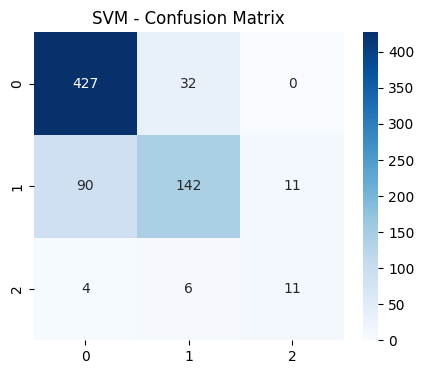

In [23]:
# SVM again with hyper-parameter tuning
#Initialize the model and fit the training data
svm_model = SVC(kernel='rbf', probability=True, random_state=23)
svm_model.fit(X_train, y_train)

# Predict with SVM model
y_pred = svm_model.predict(X_test)


# Print the results
print("\nSVM Classifier Results:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM - Confusion Matrix')

Ok after tuning the model somewhat to use the radial basis function instead of just the linear SVM kerenel, there is a large improvment in the classification the precision and F1 scores for both the sedimentary and metamorphic rocks are higher indicating that the rbf kernel is doing a much better job at classifying the data than the linear model. This is a good start. Next I will try a more comprehensive method to find the optimal parameters for the model using the GridSearchCV method from sci-kit learn. I selected the grid search method here because

Optimal Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

SVM Classifier Results:
              precision    recall  f1-score   support

     igneous       0.86      0.89      0.88       459
 metamorphic       0.75      0.71      0.73       243
 sedimentary       0.53      0.43      0.47        21

    accuracy                           0.82       723
   macro avg       0.71      0.68      0.69       723
weighted avg       0.81      0.82      0.82       723



Text(0.5, 1.0, 'SVM - Confusion Matrix')

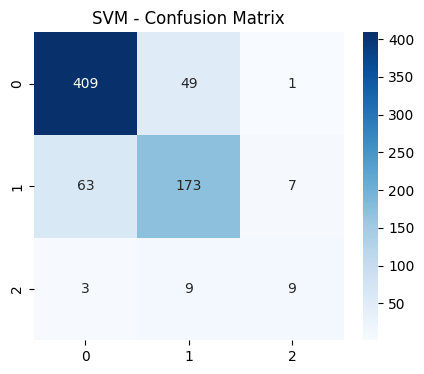

In [24]:
# Use GridSearCV to search for the correct parameter space for the SVM then re-run the SVM
parameters = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}

svm_model = SVC(probability=True, random_state=23)
clf = GridSearchCV(svm_model, parameters)
clf.fit(X_train, y_train)

# Predict with SVM model
y_pred = clf.predict(X_test)

# Print the optimal parameters
print("Optimal Parameters:", clf.best_params_)

# Print the results
print("\nSVM Classifier Results:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM - Confusion Matrix')

THe hyper-parameter tuning using the grid-search resulted in an optimal parameter space of C=1, gamma=1 for the rbf kernel which I suspect is better based on previous information. The larger value of C (compared to a value less than 1 allows for fewer misclassifications and therefore a smaller margin between the classes. Similarly a larger gamma allows the model to have a more complex boundary and so it less general. There are obvious tradeoffs between using a higher or lower C and gamma. Since these values are determiend directly by the GridSearchCV function to optimize the classification, I will stick with what it gave me, but note that these values (while not incredibly high) do sugest that the model may not be as general as we would hope for, but is still likely not fit explicitly to this data. It is clear though that evaluating the scoring for this that we got better precision accuracy and an f1 score than the previous models above, so it is doing okay on this data!

# Gradient Boosting Classifier


Gradient Boosting Classifier Results:
              precision    recall  f1-score   support

     igneous       0.84      0.91      0.88       459
 metamorphic       0.77      0.63      0.69       243
 sedimentary       0.40      0.48      0.43        21

    accuracy                           0.80       723
   macro avg       0.67      0.67      0.67       723
weighted avg       0.80      0.80      0.80       723



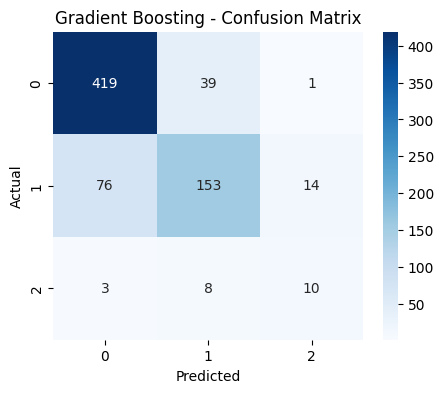

CPU times: user 2.12 s, sys: 182 ms, total: 2.3 s
Wall time: 2.09 s


In [25]:
%%time

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=23)
gb_model.fit(X_train, y_train)

# Predict with Gradient Boosting model
y_pred = gb_model.predict(X_test)

# Evaluate Gradient Boosting model
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nGradient Boosting Classifier Results:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


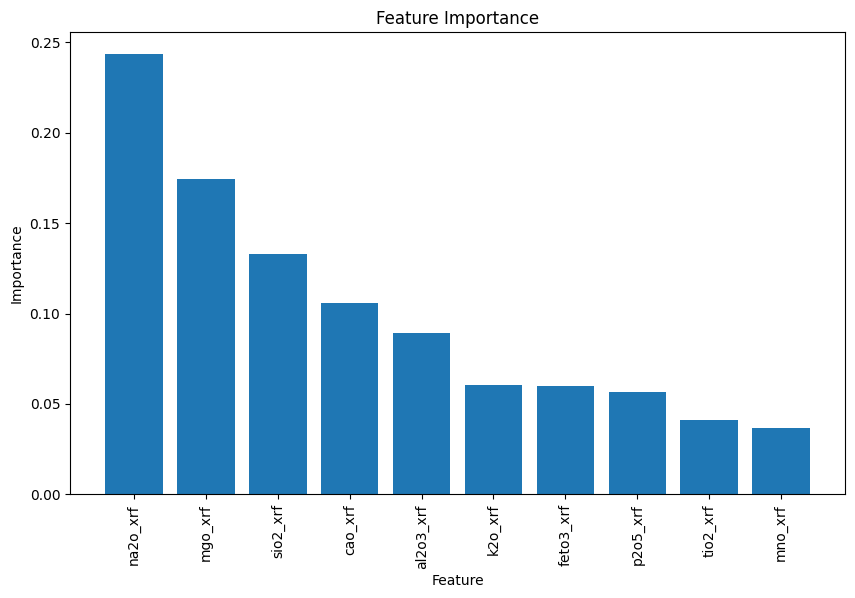

In [26]:
# Evaluate feature importance for the gradient boosting classifier
feature_importances = gb_model.feature_importances_
feature_names = rock.columns
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

The second model I ran was the Gradient Boosting Classifier. Overall the outcome of this classifier is similar to the SVM. It appears to have done a similar job with the igneous rock classification and similar job for metamorphic. There is still not a lot to be said about the sedimentary rocks because there are so few samples for them. This model feels very similar to the SVM with one exception which is the feature importance. Since I obtained a better overall classification using the rbf kernel I kept that sreuslt but the coefficients are not avaialble for non-linear kernels in SVM meaning that I cannot evaluate the feature importance for the SVM like I can for the gradient boosting classifier. In this specific model run the sodium has the highest feature importance followed by magnesium then silica. I believe that the sodium is probably related to the presence of plagiocalse in specific igneous or metamorphic samples whereas the magnedium may help differentiate common igneous rocks like basalt from metamorphic rocks. Silica has the third highest feature importance despite having the highest mean composition in most rocks, probably it is less useful for classification because it is so common in so many rocks, but it is likeyly useful for differentiating certain basalts or sedimentary rocks from other rocks like granite.


# Decision Tree Classifier


Decision Tree Classifier Results:
              precision    recall  f1-score   support

     igneous       0.83      0.86      0.84       459
 metamorphic       0.69      0.66      0.67       243
 sedimentary       0.53      0.43      0.47        21

    accuracy                           0.78       723
   macro avg       0.68      0.65      0.66       723
weighted avg       0.77      0.78      0.78       723



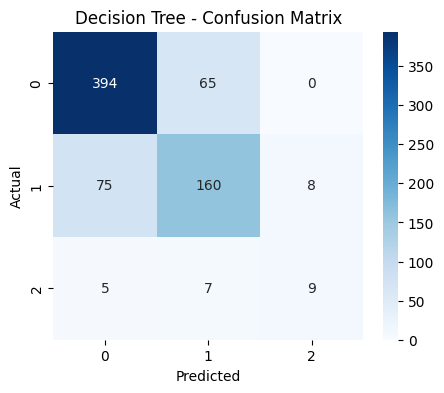

CPU times: user 187 ms, sys: 186 ms, total: 373 ms
Wall time: 138 ms


In [27]:
%%time

# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=23, max_depth=5)
dt_model.fit(X_train, y_train)

# Predict with Decision Tree model
y_pred = dt_model.predict(X_test)

# Evaluate Decision Tree model
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nDecision Tree Classifier Results:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


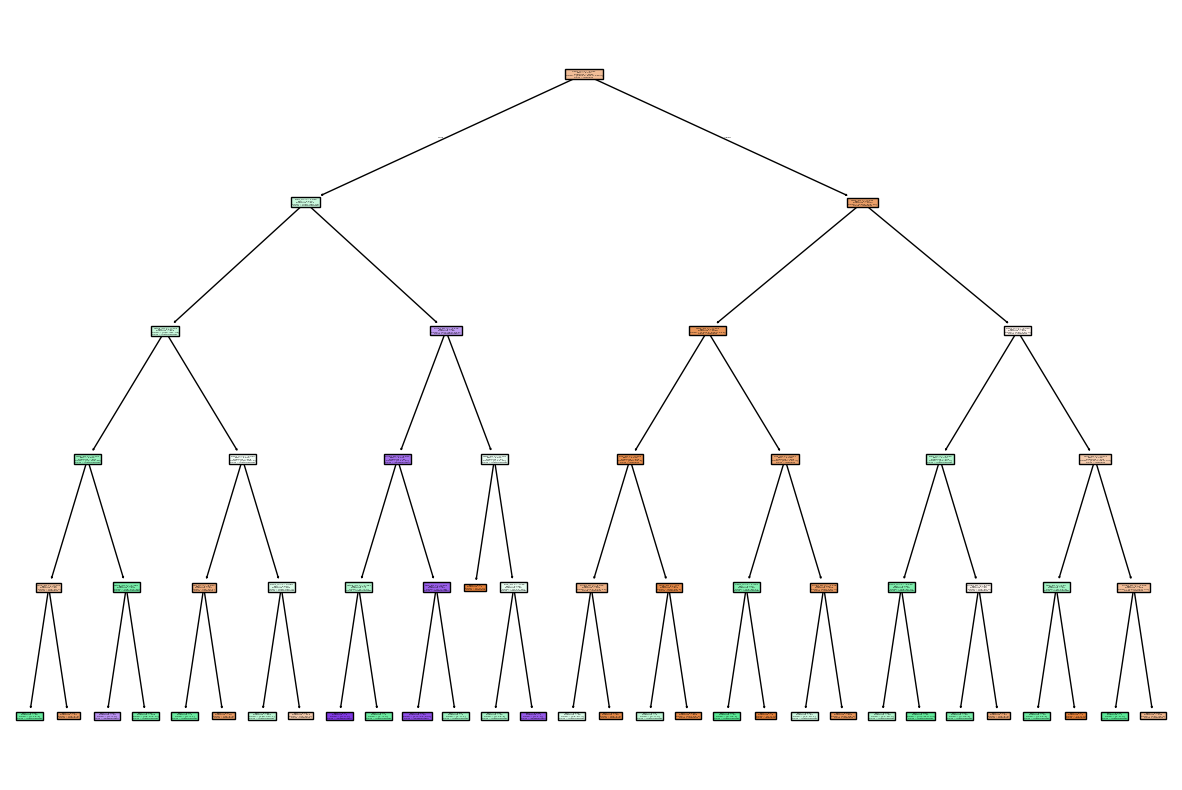

In [28]:
# Plot the Decision Tree
plt.figure(figsize=(15, 10))  # Adjust figure size

# Get feature names from the original 'rock' DataFrame before scaling
feature_names = rock.columns
plot_tree(dt_model, filled=True, feature_names=feature_names, class_names=['Igneous', 'Metamorphic', 'Sedimentary'])
plt.show()

I really love this model because it shows me pretty clearly what is happening at every step in order to determine if the rock is igneous, metamorphic or sedimentary. It is not esoteric like some of the other models I tried. Strictly speaking the precision and recall as well as the accuracy and weighted f1 scores are all slightly lower than the Gradient Boosting Model above so overall it may not perform as well in terms of classification, but this is really helpful because it shows me exactly what decisions it is making, it is really easy to interpret and find out what are the important factors for classifying a rock. I trimmed the tree also to limit the depth to 5 branch nodes, because the tree was too deep when this hyper-parameter was not tuned. This retains a similar quality of classification for this dataset while preventing it from becoming overfit to the data. I think this is a great model type overall.

# Balance Dataset by generating synthetic data

Since the dataset wa so heavility unbalanced with so much of the data being represented by igenous and metamorphic rocks with so few sedimentary rocks, I decided to quickly re-evaluate all of the different models with the same hyper-parameters but after synthetically generating data to balance the dataset. I generated data using SMOTE.


In [29]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=23)
X_resampled, y_resampled = smote.fit_resample(X, target)

# Split balanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=23)

print("Original class distribution:\n", pd.Series(target).value_counts())
print("\nBalanced class distribution:\n", pd.Series(y_resampled).value_counts())


Original class distribution:
 xndryclass
igneous        2383
metamorphic    1105
sedimentary     126
Name: count, dtype: int64

Balanced class distribution:
 xndryclass
metamorphic    2383
igneous        2383
sedimentary    2383
Name: count, dtype: int64


# SVM w/ Balanced Data


SVM Classifier Results:
              precision    recall  f1-score   support

     igneous       0.86      0.80      0.83       465
 metamorphic       0.80      0.83      0.82       492
 sedimentary       0.94      0.96      0.95       473

    accuracy                           0.87      1430
   macro avg       0.87      0.87      0.87      1430
weighted avg       0.87      0.87      0.86      1430



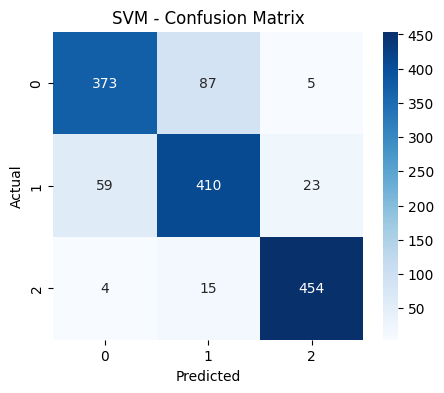


Support Vectors:
 [[ 0.59482197  0.43523204 -0.89913193 ... -0.86582338 -0.20897392
  -0.47204137]
 [ 0.2465339   0.16142091 -0.15362588 ...  0.08590571  0.16571694
  -0.08899549]
 [-0.10175418  0.1842385   0.16161668 ...  0.45431697 -0.02767189
  -0.08899549]
 ...
 [-2.51817316 -2.90645646 -1.39627957 ... -1.13437101 -0.240139
  -0.03320206]
 [ 2.37621621 -2.51279032 -1.21404176 ... -0.98751787 -0.15203363
  -0.469525  ]
 [ 1.03944505 -3.05357818 -1.49553678 ... -1.14213183 -0.26940793
   0.50298451]]

Dual Coefficients:
 [[ 1.          1.          1.         ... -0.38210529 -0.
  -0.96321718]
 [ 0.          0.02122226  1.         ... -0.36342027 -1.
  -1.        ]]

Number of Support Vectors per Class:
 [ 956 1292  479]
CPU times: user 3.6 s, sys: 150 ms, total: 3.75 s
Wall time: 3.55 s


In [30]:
%%time

# Train SVM model with probability enabled
svm_model = SVC(kernel='rbf', C=1, gamma=1, probability=True, random_state=23)
svm_model.fit(X_train, y_train)

# Predict with SVM model
y_pred = svm_model.predict(X_test)

# Evaluate SVM model
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nSVM Classifier Results:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Analyze support vectors
print("\nSupport Vectors:\n", svm_model.support_vectors_)
print("\nDual Coefficients:\n", svm_model.dual_coef_)
print("\nNumber of Support Vectors per Class:\n", svm_model.n_support_)


With the balanced data the SVM has the most trouble classifiying the igneous rocks with a lower recall and f1 score than the unbalanced data and lots of missed classifications that are classified as metamorphic instead of igneous.

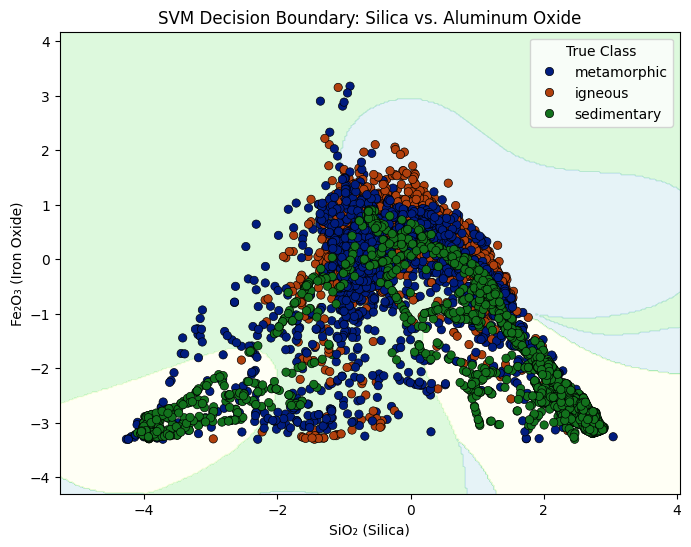

In [31]:
# Extract SiO2 and Al2O3 columns
si_o2_index = list(rock.columns).index('sio2_xrf')
al2_o3_index = list(rock.columns).index('al2o3_xrf')

X_subset = X_resampled[:, [si_o2_index, al2_o3_index]]
# Convert y_resampled to numerical labels using LabelEncoder
le = LabelEncoder()
y_subset = le.fit_transform(y_resampled)  # Convert to numerical labels

# Train an SVM model only on these two features
svm_2d = SVC(kernel='rbf', probability=True, random_state=23)
svm_2d.fit(X_subset, y_subset)

# Create a mesh grid for the decision boundary
x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

# Predict classes for mesh grid points
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define a discrete colormap matching class labels
cmap = ListedColormap(['lightblue', 'lightgreen', 'lightyellow'])

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)  # Categorical decision regions

# Plot actual data points
# Convert y_subset back to original labels for plotting
y_subset_original = le.inverse_transform(y_subset)
sns.scatterplot(x=X_subset[:, 0], y=X_subset[:, 1], hue=y_subset_original, edgecolor='k', palette='dark')

plt.xlabel("SiO₂ (Silica)")
plt.ylabel("Fe₂O₃ (Iron Oxide)")
plt.title("SVM Decision Boundary: Silica vs. Aluminum Oxide")
plt.legend(title="True Class")
plt.show()

The above figure shows the SVM classified with only the Iron and the Silica data which i seleccted becuase they had an interesting trend indicated in the pair plot during EDA. I decided to select jsut these because I wanted to be able to plot the decision boundaries that are generated on a 2-d representation for the sake of understanding what it looks like. The complex boundaries here are the result of the radial basis function kernel which projects the data into a higher dimension to generate the suport vector boundaries.

# Gradient Boosting Classifier w/ Balanced Data


Gradient Boosting Classifier Results:
              precision    recall  f1-score   support

     igneous       0.80      0.81      0.81       465
 metamorphic       0.78      0.76      0.77       492
 sedimentary       0.90      0.93      0.92       473

    accuracy                           0.83      1430
   macro avg       0.83      0.83      0.83      1430
weighted avg       0.83      0.83      0.83      1430



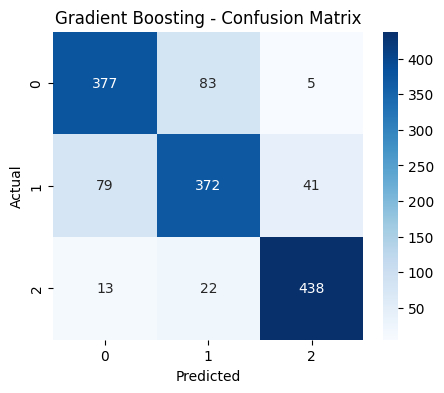

CPU times: user 5.02 s, sys: 161 ms, total: 5.18 s
Wall time: 4.97 s


In [32]:
%%time

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=23)
gb_model.fit(X_train, y_train)

# Predict with Gradient Boosting model
y_pred = gb_model.predict(X_test)

# Evaluate Gradient Boosting model
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nGradient Boosting Classifier Results:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


The gradient boosting classifier does a similar job with the igneous and metamorphic rocks here as shown by the similar precision, recall and f1 scores with the previous data. However the main difference that I notice is that the precision, reccall and f1 score a incredibly high for the sedimentary rock which was before in the 40s for this model. For this specific data this suggests that the model works well, however it is also possible that the data are overfit to this specific dataset and wonk carry over very effectively for other rock classification questions.

# Decision Tree Classifier


Decision Tree Classifier Results:
              precision    recall  f1-score   support

     igneous       0.74      0.81      0.77       465
 metamorphic       0.75      0.70      0.73       492
 sedimentary       0.88      0.87      0.88       473

    accuracy                           0.79      1430
   macro avg       0.79      0.79      0.79      1430
weighted avg       0.79      0.79      0.79      1430



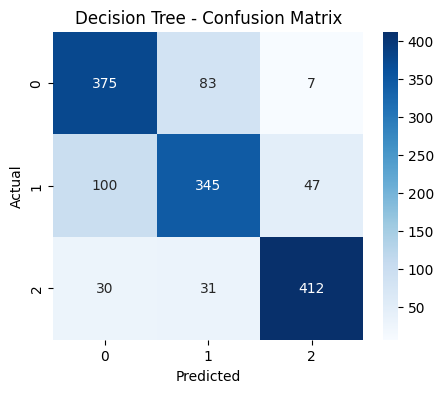

CPU times: user 207 ms, sys: 190 ms, total: 396 ms
Wall time: 177 ms


In [33]:
%%time

# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=23, max_depth=5)
dt_model.fit(X_train, y_train)

# Predict with Decision Tree model
y_pred = dt_model.predict(X_test)

# Evaluate Decision Tree model
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nDecision Tree Classifier Results:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


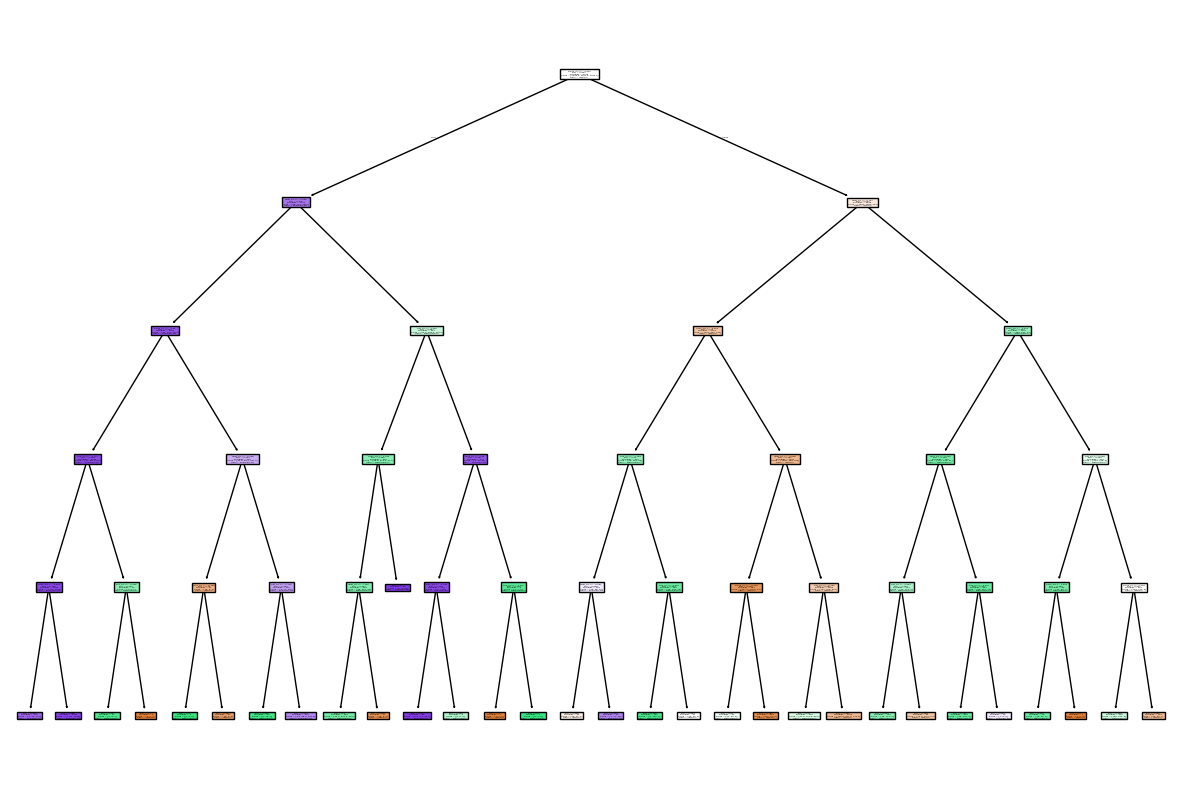

In [34]:
# Plot the decision tree for the balanced data
plt.figure(figsize=(15, 10))

# Get feature names from the original 'rock' DataFrame before scaling
feature_names = rock.columns
plot_tree(dt_model, filled=True, feature_names=feature_names, class_names=['Igneous', 'Metamorphic', 'Sedimentary'])
plt.show()

My investigation using the balancded data to predict the classes suggests that it is better than the unbalanced data because it is able to do a much better job of predicting the sedimentary rocks based on more training data avaialble, while retaining much of the ability to classify the other rocks types.

# Questions and Answers

## Which method do you like the most?
I really liked two models for different reasons. In terms of accuracy of classification the gradient boosting classifier did a really good job overall.  Compared to the SVM I did not see much of an improvement in either direciton in terms of the accuracy and other scoring methods. The SVM was slightly faster than the gradient boosting classifier but the main reason i preferred the gradient boosting classifier is that i could evaluate the feature importance which feels very necessary. That being said I loved the Decision Tree Classifier more than either of the other two because it is really easy to evaluate what the model is doing and that makes it really useful for learning what factors matter for the classification of the data. The decision tree that it produces is incredible for understanding what is happening with each step. on the

## Which method did you like the least?
I least liked the support vector machine. It did not significantly improve on the results over the gradient booster and when I used a non-linear kernel for it, I wasn't able to evaluate the feature importane. Since the feature importance is a good way to understand what the model is doing and what features mtter for the calssification, I don't like that it is harder to evaluate than the other models here. I think that it has its place particualrly because it is a commonly used and fairly easy to understand model, but I think that it was less useful without the feature importance.

## How did you score these supervised models?
I used multiple scoring methods that I compared for each class, these included the precision, recall, f1 score and accuracy as well as weighted overall averages for how well the different models did. I also plotted a confusion matrix which turns out to be a really helpful way to interpret these results. The confusion matrix is my favorite way of scoring because you can see not only the scoring metrics but also what a specific feature is being mis-classified as.

## Did the output align with your geologic understanding?
The thing about these models is that (except for the decision tree which I can get some information about except that it is too small) is that I don't know what paramters matter the most for all of these classifications. I can evaluate how well each of them does at classifying the data but that does not mean that I am able to understand the weights of the features that are used to make these classifications. So I am not certain that I know how well these are doing at classifying based on robust geologic parameters that I agree with. i suspect that looking at the feature importance for the gradient boosting classifier that presence of plagioclase has something to do with the classification because it has the highest importance and this makes sense since it will be more common in igneous rocks, mostly absent from sedimentary and present in variable quantities and compositions in metamorphic. So in a way I am able to make hypotheses about the classifications, but I would want to evaluate the decision tree because I think that will give me the best understanding about what the model is doing and allow me to evaluate it effectively.

## Did you hyperparameter tune? Why or why not?
I did hyperparameter tune the SVM model, i changed the kernel to experiment with the linear and rbf kernels and used the GridSearchCV function to find the optimal parameters from a small range of values. The rbf did a little bit better than the linear kernel so that is the one that I ended up applying. For the C and gamma I also tuned these parameters to optimize the classification I was getting. This helped improve the model significantly over the baseline hyperparametrs and I am glad that I did it because it really improved the model. I also tuned the depth of the decision tree because it was too deep based on the initial classification. I did not want it to be too overfit to the data which is a problem with decision tree calssifiers, so I reduced the depth to prevent overfitting and generalize the model slightly.

## How did you split your data? and why does that make sense for this dataset?
I just did a simple split into a training and testing subset where the testing subset is 20% of the total number of samples. I did not perform any specific alterations on this procedure to account for autocorrelation in any way because my data was a simple tabular data format without location information, it was just classifications of rock types, so the autocorellation issue is not relevant. If this had been spatially representative data where the location did matter than I woul have considered performing some sort of binning and splitting method to gain a representative sample of the data while avoiding autocorrealtion in the data.

## What did you want to learn more about?

After this I feel fairly good about most aspects of this work. I think that the one thing I would like to continue learning about is the decision tree and wold want to learn how to implement a random forest as well which should help with the overfitting problem. Another feature of the random forest I know is that there is a regressor model not just a classification model, and since it is so highly interprtable I would be interested in trying this.

## Did you pre-process your data? Do all models require pre-processing?

I did preprocess my data, before I split the data I normalized it to account for the difference in scale between the different parameters. This should ensure that my models ran effectively because it was on the same scale. I also removed NaN values to prevent errors while running the models. Other than that I performed simple pre-processing like EDA. I think it is likely that all models require pre-processing because the data that is being fed into them is expected to be in a specific format and that format as far as I am aware is fairily inconsistent with most of the types of data that we collect as geologists. That being said there may be specific models or specific machine learning tools that actually do not like scaled data and either prefer or are able to effectively process non-scaled data, however I do not currently know what those are. So for now I wil continue scaling my data.